In [233]:
import requests
import urllib
import asyncio
import aiohttp
from bs4 import BeautifulSoup
import time
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [234]:
top_10_actors_2019 = {
    'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005',
    'Chris Hemsworth': 'https://www.imdb.com/name/nm1165110',
    'Robert Downey Jr.': 'https://www.imdb.com/name/nm0000375',
    'Akshay Kumar': 'https://www.imdb.com/name/nm0474774',
    'Jackie Chan': 'https://www.imdb.com/name/nm0000329',
    'Bradley Cooper': 'https://www.imdb.com/name/nm0177896',
    'Adam Sandler': 'https://www.imdb.com/name/nm0001191',
    'Scarlett Johansson': 'https://www.imdb.com/name/nm0424060',
    'Sofia Vergara': 'https://www.imdb.com/name/nm0005527',
    'Chris Evans': 'https://www.imdb.com/name/nm0262635'
}

In [229]:
#support functions
def full_feature_movies_check(movie_soup):
    if '(TV Series' in movie_soup.text:
        return False
    elif '(Short)' in movie_soup.text:
        return False
    elif '(Video Game)' in movie_soup.text:
        return False
    elif '(Video short)' in movie_soup.text:
        return False
    elif '(Video)' in movie_soup.text:
        return False
    elif '(TV Movie)' in movie_soup.text:
        return False
    elif '(TV Mini-Series' in movie_soup.text:
        return False
    elif '(TV Series short)' in movie_soup.text:
        return False
    elif '(TV Special)' in movie_soup.text:
        return False
    elif '(TV Short)' in movie_soup.text:
        return False
    elif '(Documentary' in movie_soup.text:
        return False
    elif movie_soup.find('a', attrs = {'class': 'in_production'}):
        return False

    return True


def get_soup(url):
    response = requests.get(url)
    return BeautifulSoup(response.text)

        
def get_actor_name(soup):
    try:
        name = soup.find('span', attrs = {'class': 'itemprop'}).text
    except:
        name = None
    return name


def get_actor_name_by_url(actor_url):
    response = requests.get(actor_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text)
        try:
            name = soup.find('span', attrs = {'class': 'itemprop'}).text
        except:
            name = None
    return name

        
async def fetch(session, url):
    async with session.get(url) as response:
        return await response.text()

    
async def fetch_sem(session, url, sem):
    async with sem:
        async with session.get(url) as response:
            return await response.text() 

In [230]:
def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):
    actors = []
    try:
        table_of_actors = cast_page_soup.find('table', attrs = {'class': 'cast_list'}).find_all('tr')
    except:
        table_of_actors = []
    
    for tr in table_of_actors:
        try:
            td = tr.find_all('td')
            if len(td) > 1:
                name_of_actor = td[1].text.strip()
                url_to_actor_page = 'https://www.imdb.com' + td[1].find('a')['href']
                #url_to_actor_page = urllib.parse.urljoin(url, url_to_actor_page)
                actors.append((name_of_actor, url_to_actor_page))
        except:
            continue
            
    if num_of_actors_limit:
        return actors[:num_of_actors_limit]
    return actors

In [232]:
def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movies = []
    try:
        filmography = actor_page_soup.find('div', attrs = {'id': 'filmography'})
        table_of_movies_head = filmography.find('div', attrs = {'id': 'filmo-head-actor', 'class': 'head'})
        if table_of_movies_head is None:
            table_of_movies_head = filmography.find('div', attrs = {'id': 'filmo-head-actress', 'class': 'head'})
        table_of_movies = table_of_movies_head.find_next_sibling().find_all('div')
    except:
        print('Filmography is not finded')
        table_of_movies = []
    
    for movie in table_of_movies:
        try:
            if 'actor' in movie.attrs.get('id', []) or 'actress' in movie.attrs.get('id', []):
                if full_feature_movies_check(movie):
                    name_of_movie = movie.find('b').find('a').text    
                    url_to_movie_page = 'https://www.imdb.com' + movie.find('b').find('a')['href']
                    movies.append((name_of_movie, url_to_movie_page))
        except:
            continue
            
    if num_of_movies_limit:
        return movies[:num_of_movies_limit]
    return movies

In [239]:
#get_movie_distance function_from_previous_week
async def get_movie_distance_old(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None, depth=3):
    actor_start_url = actor_start_url.replace('https://www.', 'https://')
    actor_end_url = actor_end_url.replace('https://www.', 'https://')
    actor_end = get_actor_name_by_url(actor_end_url)
    actor_start_name = get_actor_name_by_url(actor_start_url)
    actors_dict = {}
    distance = 1
    actors_to_check = [(actor_start_name, actor_start_url)]
    while distance < depth:
        print('Distance checking:', distance)
        actors = []
        print('Need to check', len(actors_to_check), 'actors')
        i = 1
        for actor in actors_to_check:
            print(i, 'Checking:', actor)
            i += 1
            one_distance_actors = []
            response = requests.get(actor[1])
            soup = BeautifulSoup(response.text)
            movies = get_movies_by_actor_soup(soup, num_of_movies_limit)
            sem = asyncio.Semaphore(90)
            try:
                async with aiohttp.ClientSession() as session:
                    coroutines = [fetch_sem(session, movie[1], sem) for movie in movies]
                    actor_responses = await asyncio.gather(*coroutines)
            except:
                actor_responses = []
                print('  Error occured while getting one distance connected actors')
            i=0
            for response in actor_responses:
                soup = BeautifulSoup(response)
                i += 1
                current_movie_actors = get_actors_by_movie_soup(soup, num_of_actors_limit)
                one_distance_actors += current_movie_actors
            current_actors = list(set(one_distance_actors))
            #print('  ', actor[0], 'is connected with', len(current_actors), 'other actors')
            actors_dict.update({_actor[0]: _actor[1] for _actor in current_actors})
            if actor_end in actors_dict:
                return distance
            actors += current_actors
        distance += 1
        actors_to_check = actors

    if actor_end in actors_dict:
        return distance
    else:
        return -1

In [248]:
#example
start = time.time()
actor_start = 'Adam Sandler'
actor_end = 'Scarlett Johansson'
async with aiohttp.ClientSession() as session:
    print(actor_start, actor_end, await get_movie_distance_old(top_10_actors_2019[actor_start],
                                                           top_10_actors_2019[actor_end]
                                                           #5, 5, 4
                                                           ))
print(time.time() - start)

Distance checking: 1
Need to check 1 actors
1 Checking: ('Adam Sandler', 'https://imdb.com/name/nm0001191')
Distance checking: 2
Need to check 556 actors
1 Checking: ('Chrissy Teigen', 'https://www.imdb.com/name/nm4178979/')
3 Checking: ('J.B. Smoove', 'https://www.imdb.com/name/nm1356578/')
Adam Sandler Scarlett Johansson 2
28.485196113586426


In [250]:
#get_movie_distance function updated
actors_checked = dict()
movies_checked = dict()

async def get_movie_distance(actor_start_url, actor_end_url, num_of_actors_limit=None, num_of_movies_limit=None, depth=3):
    global actors_checked
    global movies_checked
    
    actor_start_url = actor_start_url.replace('https://www.', 'https://')
    actor_end_url = actor_end_url.replace('https://www.', 'https://')
    
    actor_end_soup = get_soup(actor_end_url)
    actor_end_name = get_actor_name(actor_end_url)
    actor_end = (actor_end_name, actor_end_url)
    if actor_end not in actors_checked:
        actor_end_movies = get_movies_by_actor_soup(actor_end_soup, num_of_movies_limit)
        actors_checked[actor_end] = actor_end_movies
    else:
        actor_end_movies = actors_checked[actor_end]
    actor_end_movies = set(actor_end_movies)
    distance = 1
    actors_to_check = [(get_actor_name_by_url(actor_start_url), actor_start_url)]
    
    while distance < depth:
        print(f'Distance checking: {distance}. Need to check {len(actors_to_check)} actors')
        actors = []
        movies = []
        i = 1
        sem = asyncio.Semaphore(100)
        try:
            async with aiohttp.ClientSession() as session:
                for actor in actors_to_check:
                    i += 1
                    if actor not in actors_checked:
                        print(f'{i}. Scraping: {actor}')
                        actor_response = await fetch_sem(session, actor[1], sem)
                        soup =  BeautifulSoup(actor_response)
                        current_actor_movies = get_movies_by_actor_soup(soup, num_of_movies_limit)
                        actors_checked[actor] = current_actor_movies
                        print(f'{actor[0]} played in {len(current_actor_movies)} movies')
                        match = actor_end_movies.intersection(set(current_actor_movies))
                        if  match:
                            match_movies = [f'{movie[0]} ({movie[1]})' for movie in match]
                            match_movies = ', '.join(match_movies)
                            print(f'MATCH by {actor} via {match_movies}, distance is {distance}')
                            return distance
                    else:
                        current_actor_movies = actors_checked[actor]
                        print(f'{i}. Already scraped: {actor} played in {len(current_actor_movies)} movies')
                        match = actor_end_movies.intersection(set(current_actor_movies))
                        if  match:
                            match_movies = [f'{movie[0]} ({movie[1]})' for movie in match]
                            match_movies = ', '.join(match_movies)
                            print(f'MATCH by {actor} via {match_movies}, distance is {distance}')
                            return distance

                    movies += current_actor_movies
                movies = list(set(movies))
                j = 1
            async with aiohttp.ClientSession() as session:            
                for movie in movies:
                    j += 1
                    if movie not in movies_checked:
                        print(f'{j} Scraping actors from: {movie}')
                        movie_response = await fetch_sem(session, movie[1], sem)
                        soup = BeautifulSoup(movie_response)
                        current_movie_actors = get_actors_by_movie_soup(soup, num_of_movies_limit)
                        movies_checked[movie] = current_movie_actors
                    else:
                        print(f'{j} Already scraped: {movie}')
                        current_movie_actors = movies_checked[movie]

                    actors += current_movie_actors
        except:
                print('Something goes wrong')
        actors_to_check = list(set(actors))
        distance += 1
    
    return -1

In [252]:
"""
'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005',
'Chris Hemsworth': 'https://www.imdb.com/name/nm1165110',
'Robert Downey Jr.': 'https://www.imdb.com/name/nm0000375',
'Akshay Kumar': 'https://www.imdb.com/name/nm0474774',
'Jackie Chan': 'https://www.imdb.com/name/nm0000329',
'Bradley Cooper': 'https://www.imdb.com/name/nm0177896',
'Adam Sandler': 'https://www.imdb.com/name/nm0001191',
'Scarlett Johansson': 'https://www.imdb.com/name/nm0424060',
'Sofia Vergara': 'https://www.imdb.com/name/nm0005527',
'Chris Evans': 'https://www.imdb.com/name/nm0262635'
"""
#example
start = time.time()
actor_start = 'Adam Sandler'
actor_end = 'Scarlett Johansson'
async with aiohttp.ClientSession() as session:
    print(actor_start, actor_end, await get_movie_distance(top_10_actors_2019[actor_start],
                                                           top_10_actors_2019[actor_end]
                                                           #5, 5, 4
                                                           ))
print(time.time() - start)

Distance checking: 1. Need to check 1 actors
2. Already scraped: ('Adam Sandler', 'https://imdb.com/name/nm0001191') played in 52 movies
2 Already scraped: ('Одноклассники', 'https://www.imdb.com/title/tt1375670/')
3 Already scraped: ('Смешанные', 'https://www.imdb.com/title/tt1086772/')
4 Already scraped: ('Чак и Ларри: Пожарная свадьба', 'https://www.imdb.com/title/tt0762107/')
5 Already scraped: ('Одноклассники 2', 'https://www.imdb.com/title/tt2191701/')
6 Already scraped: ('Все по новой', 'https://www.imdb.com/title/tt4769836/')
7 Already scraped: ('Загадочное убийство', 'https://www.imdb.com/title/tt1618434/')
8 Already scraped: ('Такие разные близнецы', 'https://www.imdb.com/title/tt0810913/')
9 Already scraped: ('Не шутите с Zоханом!', 'https://www.imdb.com/title/tt0960144/')
10 Already scraped: ('Монстры на каникулах', 'https://www.imdb.com/title/tt0837562/')
11 Already scraped: ('Певец на свадьбе', 'https://www.imdb.com/title/tt0120888/')
12 Already scraped: ('Любовь, сбивающ

In [225]:
async def get_movie_descriptions_by_actor_soup(actor_page_soup):
    movies = get_movies_by_actor_soup(actor_page_soup)
    movie_descriptions = []
    async with aiohttp.ClientSession() as session:
        sem = asyncio.Semaphore(90)
        coroutines = [fetch_sem(session, movie[1], sem) for movie in movies]
        responses = await asyncio.gather(*coroutines)
    for response in responses:
        movie_soup = BeautifulSoup(response)
        try:
            summary = movie_soup.find('div',  attrs = {'class': 'summary_text'})
            if summary:
                movie_description = summary.text.strip()
                try:
                    a = summary.find('a')
                    if a:
                        if a.text == 'See full summary':
                            url = 'https://www.imdb.com' + a['href']
                            soup = get_soup(url)
                            summary_header = soup.find('h4', attrs={'id': 'summaries'})
                            summary = summary_header.find_next_sibling().find('p')
                            movie_description = summary.text
                except:
                    print('error')
                    pass
                movie_descriptions.append(movie_description)
        except:
            print('error2')
            continue
    return movie_descriptions

In [191]:
top_10_actor_names = [actor for actor in top_10_actors_2019]
data = [[0, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 0, 1, 2, 2, 1, 2, 1, 2, 1],
        [2, 1, 0, 2, 2, 1, 2, 1, 1, 1],
        [2, 2, 2, 0, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 0, 2, 2, 2, 2, 2],
        [2, 1, 1, 2, 2, 0, 2, 1, 2, 1],
        [2, 2, 2, 2, 2, 2, 0, 2, 2, 2],
        [2, 1, 1, 2, 2, 1, 2, 0, 1, 1],
        [2, 2, 1, 2, 2, 2, 2, 1, 0, 2],
        [2, 1, 1, 2, 2, 1, 2, 1, 2, 0]]
pd_data = pd.DataFrame(columns=top_10_actor_names, index=top_10_actor_names, data=data)
pd_data

,Dwayne Johnson,Chris Hemsworth,Robert Downey Jr.,Akshay Kumar,Jackie Chan,Bradley Cooper,Adam Sandler,Scarlett Johansson,Sofia Vergara,Chris Evans
Dwayne Johnson,0,2,2,2,2,2,2,2,2,2
Chris Hemsworth,2,0,1,2,2,1,2,1,2,1
Robert Downey Jr.,2,1,0,2,2,1,2,1,1,1
Akshay Kumar,2,2,2,0,2,2,2,2,2,2
Jackie Chan,2,2,2,2,0,2,2,2,2,2
Bradley Cooper,2,1,1,2,2,0,2,1,2,1
Adam Sandler,2,2,2,2,2,2,0,2,2,2
Scarlett Johansson,2,1,1,2,2,1,2,0,1,1
Sofia Vergara,2,2,1,2,2,2,2,1,0,2
Chris Evans,2,1,1,2,2,1,2,1,2,0


In [254]:
pd_data.to_csv('top_10_actors_2019_distancies.csv')

In [172]:
G = nx.Graph()
G.add_nodes_from([actor for actor in top_10_actors_2019])
one_distance_actors = [
    ('Chris Hemsworth', 'Robert Downey Jr.'),
    ('Chris Hemsworth', 'Bradley Cooper'),
    ('Chris Hemsworth', 'Scarlett Johansson'),
    ('Chris Hemsworth', 'Chris Evans'),
    ('Robert Downey Jr.', 'Bradley Cooper'),
    ('Robert Downey Jr.', 'Scarlett Johansson'),
    ('Robert Downey Jr.', 'Chris Evans'),
    ('Bradley Cooper', 'Scarlett Johansson'),
    ('Bradley Cooper', 'Chris Evans'),
    ('Scarlett Johansson', 'Chris Evans'),
    ('Scarlett Johansson', 'Sofia Vergara'),
    ('Robert Downey Jr.', 'Sofia Vergara')
]
G.add_edges_from(one_distance_actors, weight=1)
two_distance_actors = [
    ('Dwayne Johnson', 'Chris Hemsworth'),
    ('Dwayne Johnson', 'Robert Downey Jr.'),
    ('Dwayne Johnson', 'Akshay Kumar'),
    ('Dwayne Johnson', 'Jackie Chan'),
    ('Dwayne Johnson', 'Bradley Cooper'),
    ('Dwayne Johnson', 'Adam Sandler'),
    ('Dwayne Johnson', 'Scarlett Johansson'),
    ('Dwayne Johnson', 'Sofia Vergara'),
    ('Dwayne Johnson', 'Chris Evans'),
    ('Akshay Kumar', 'Chris Hemsworth'),
    ('Akshay Kumar', 'Robert Downey Jr.'),
    ('Akshay Kumar', 'Jackie Chan'),
    ('Akshay Kumar', 'Bradley Cooper'),
    ('Akshay Kumar', 'Adam Sandler'),
    ('Akshay Kumar', 'Scarlett Johansson'),
    ('Akshay Kumar', 'Sofia Vergara'),
    ('Akshay Kumar', 'Chris Evans'),
    ('Jackie Chan', 'Chris Hemsworth'),
    ('Jackie Chan', 'Robert Downey Jr.'),
    ('Jackie Chan', 'Bradley Cooper'),
    ('Jackie Chan', 'Adam Sandler'),
    ('Jackie Chan', 'Scarlett Johansson'),
    ('Jackie Chan', 'Sofia Vergara'),
    ('Jackie Chan', 'Chris Evans'),
    ('Adam Sandler', 'Chris Hemsworth'),
    ('Adam Sandler', 'Robert Downey Jr.'),
    ('Adam Sandler', 'Bradley Cooper'),
    ('Adam Sandler', 'Scarlett Johansson'),
    ('Adam Sandler', 'Sofia Vergara'),
    ('Adam Sandler', 'Chris Evans'),
    ('Sofia Vergara', 'Chris Hemsworth'),
    ('Sofia Vergara', 'Bradley Cooper'),
    ('Sofia Vergara', 'Chris Evans')   
]
G.add_edges_from(two_distance_actors, weight=2)
edge_colors = ['green' if not edge in one_distance_actors else 'red' for edge in G.edges()]
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])

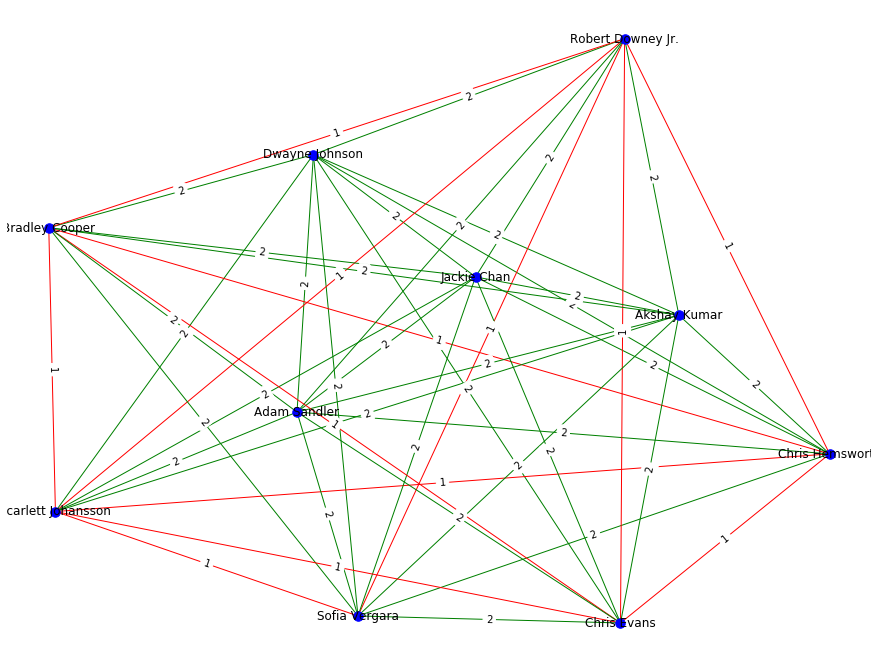

In [174]:
plt.figure(figsize=(12,9))
pos=nx.spring_layout(G)
nx.draw(G, pos, node_color='blue', node_size=90, with_labels=True, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

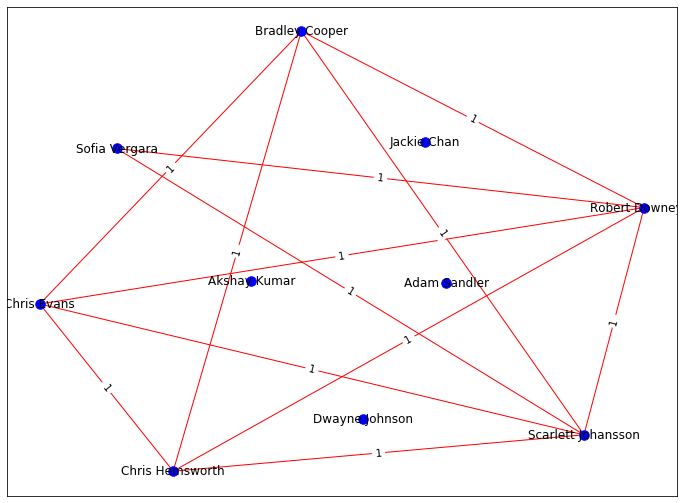

In [189]:
plt.figure(figsize=(12,9))
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=90, with_labels=True)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=one_distance_actors, width=1, edge_color='red')
nx.draw_networkx_edge_labels(G, pos, edge_labels={n:lab for n,lab in edge_labels.items() if n in one_distance_actors})
plt.show()

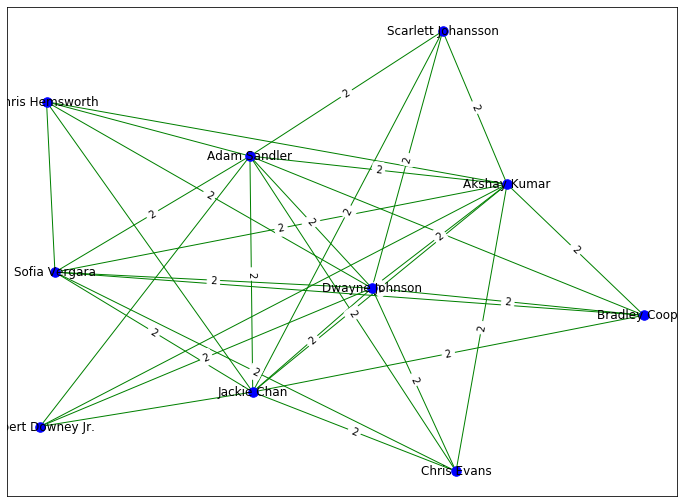

In [190]:
plt.figure(figsize=(12,9))
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=90, with_labels=True)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=two_distance_actors, width=1, edge_color='green')
nx.draw_networkx_edge_labels(G, pos, edge_labels={n:lab for n,lab in edge_labels.items() if n in two_distance_actors})
plt.show()

In [226]:
for actor in top_10_actors_2019:
    filename = '_'.join(actor.split())
    url = top_10_actors_2019[actor]
    actor_page_soup = get_soup(url)
    async with aiohttp.ClientSession() as session:
        desc = await get_movie_descriptions_by_actor_soup(actor_page_soup)
        with open(filename + '.txt','w') as f:
            f.write('\n'.join(desc))
    print(filename + '.txt writed to disk')

Dwayne_Johnson.txt writed to disk
Chris_Hemsworth.txt writed to disk
Robert_Downey_Jr..txt writed to disk
Akshay_Kumar.txt writed to disk
Jackie_Chan.txt writed to disk
Bradley_Cooper.txt writed to disk
Adam_Sandler.txt writed to disk
Scarlett_Johansson.txt writed to disk
Sofia_Vergara.txt writed to disk
Chris_Evans.txt writed to disk


Dwayne Johnson


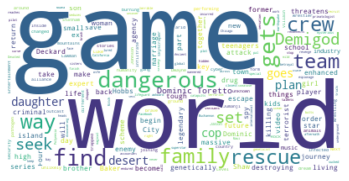

Chris Hemsworth


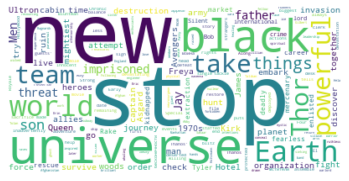

Robert Downey Jr.


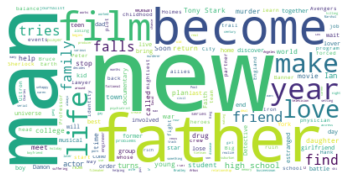

Akshay Kumar


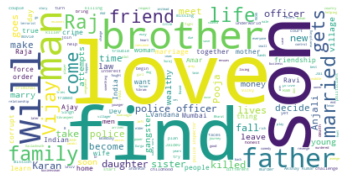

Jackie Chan


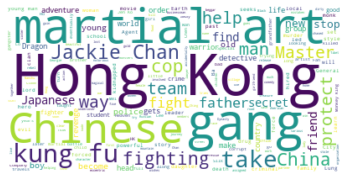

Bradley Cooper


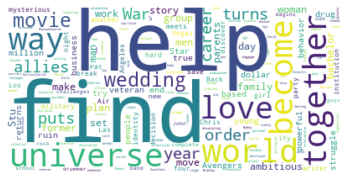

Adam Sandler


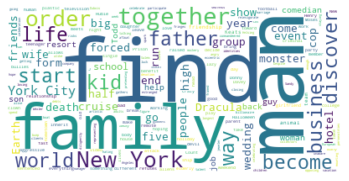

Scarlett Johansson


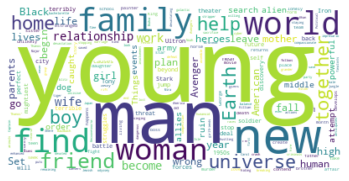

Sofia Vergara


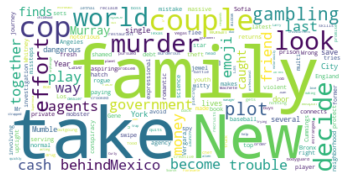

Chris Evans


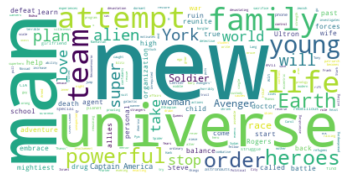

In [247]:
for actor in top_10_actors_2019:
    print(actor)
    filename = '_'.join(actor.split()) + '.txt'
    desc = []
    with open(filename,'r') as f:
        desc = [line.strip() for line in f]
    text = ''.join(desc)
    stopwords = set(STOPWORDS)
    stopwords.update(['See full summary', 'Add a plot', '»', 'one', 'two', 'three', 'must'])
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()